In [1]:
from autoencoders import *
from pdb_utils import *

import pickle
import numpy as np
import pandas as pd
import random

import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from functools import partial
import sys

from Bio import PDB
import numpy as np
import os
import cv2

import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression

import time

In [2]:
def nice_time(start,end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Runtime: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

In [3]:
with open('pickle files/fold_groups.pkl', 'r') as f:
    fold_dict = pickle.load(f)

In [4]:
with open('pickle files/label_dict.pkl', 'rb') as f:
    label_dict = pickle.load(f)

In [14]:
def pdbClassifier(X,y,label_dict,classifier):           
    uniques = list(set(y))
    print("Number of labels: %d"%len(uniques))
    group2id = dict(zip(uniques, range(len(uniques))))
    y = np.array(list(map(lambda x: group2id[x], y)))
    
    # Stratified Cross Validation
    sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
    C = 1
    acc, prec, rec = 0,0,0
    s_time = time.time()
    for train_index, test_index in sss.split(X, y):
        print("\nStratified Cross Validation - %d"%C)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        print("Training...")
        # Fitting Random Forest Classification to the Training set
        classifier = classifier
        classifier.fit(X_train, y_train)
        
        # Print train/test accuracy
        y_pred_train = classifier.predict(X_train)
        print "Train accuracy: ",accuracy_score(y_train, y_pred_train)
        y_pred_test = classifier.predict(X_test)
        print "Test accuracy: ",accuracy_score(y_test, y_pred_test)
        
        acc+=accuracy_score(y_test, y_pred_test)
        prec+=precision_score(y_test, y_pred_test, average='weighted')
        rec+=recall_score(y_test, y_pred_test, average='weighted')
        C+=1
    end = time.time()
    nice_time(s_time,end)

    print "\naverage accuracy_score: ", acc/10
    print "average precision_score: ", prec/10
    print "average recall_score: ", rec/10

In [5]:
selected_folds = filter(lambda x: x[1]==14, map(lambda x: (x[0],len(x[1])), fold_dict.items()))[:10]
len(selected_folds)

10

In [6]:
s_time = time.time()
structures = []

for fold,_ in selected_folds:
    for pdb in fold_dict[fold]:
        pdb_path = os.path.join("PDBs", pdb+".pdb")
        parser = PDB.PDBParser()
        structure = parser.get_structure(pdb, pdb_path)
        structures.append(structure)
end = time.time()
nice_time(s_time,end)

Runtime: 00:00:09.75


## Fold Classification with Strategy 1

In [61]:
print("\nCreating distance matrices with Strategy 1")
s_time = time.time()
matrixdict_s1 = DistanceMatrixDict(structures, resize_strategy="strategy1", resize_to=(64,64),removeSymmetry=True)
end = time.time()
nice_time(s_time,end)


Creating distance matrices with Strategy 1
Runtime: 00:00:25.68


In [62]:
pdb_names, features = list(matrixdict_s1.keys()), list(matrixdict_s1.values())
input_size = len(features[0])
print("Number of samples: %d"%len(pdb_names))
print("Input size: %d"%input_size)

Number of samples: 140
Input size: 2016


In [63]:
print("Linear Autoencoder - 100 epochs")
s_time = time.time()
new_features, loss = LinearAutoencoder(features, input_size, 50, 100, learning_rate=0.0001)
end = time.time()
nice_time(s_time,end)

Linear Autoencoder - 100 epochs
Runtime: 00:00:13.74


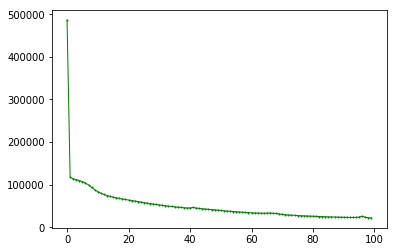

In [64]:
# LOSS GRAPH
fig, ax = plt.subplots()
ax.plot(range(0,len(loss)), loss, 'go-', linewidth=1, markersize=1)

In [66]:
X = np.array(new_features)
y_family, y_superfamily, y_fold, y_class = [], [], [], []

for pdb in pdb_names:
    y_family.append(label_dict[pdb])
    y_superfamily.append(".".join(label_dict[pdb].split(".")[:3]))
    y_fold.append(".".join(label_dict[pdb].split(".")[:2]))
    y_class.append(".".join(label_dict[pdb].split(".")[0]))
print(y_family[0], y_superfamily[0], y_fold[0], y_class[0])

('c.119.1.0', 'c.119.1', 'c.119', 'c')


In [67]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, penalty="l2", multi_class='multinomial', solver='lbfgs')
pdbClassifier(X, y_fold, label_dict, clf)

Number of labels: 10

Stratified Cross Validation - 1
Training...
Train accuracy:  1.0
Test accuracy:  0.75

Stratified Cross Validation - 2
Training...
Train accuracy:  1.0
Test accuracy:  0.8571428571428571

Stratified Cross Validation - 3
Training...
Train accuracy:  1.0
Test accuracy:  0.8928571428571429

Stratified Cross Validation - 4
Training...
Train accuracy:  1.0
Test accuracy:  0.8928571428571429

Stratified Cross Validation - 5
Training...
Train accuracy:  1.0
Test accuracy:  0.6785714285714286

Stratified Cross Validation - 6
Training...
Train accuracy:  1.0
Test accuracy:  0.8928571428571429

Stratified Cross Validation - 7
Training...
Train accuracy:  1.0
Test accuracy:  0.8571428571428571

Stratified Cross Validation - 8
Training...
Train accuracy:  1.0
Test accuracy:  0.8214285714285714

Stratified Cross Validation - 9
Training...
Train accuracy:  1.0
Test accuracy:  0.8928571428571429

Stratified Cross Validation - 10
Training...
Train accuracy:  1.0
Test accuracy:  0

## Fold Classification with Strategy 2

In [26]:
print("\nCreating distance matrices with Strategy 2")
s_time = time.time()
matrixdict_s2 = DistanceMatrixDict(structures, resize_strategy="strategy2", resize_to=(64,64), sample_size=5)
end = time.time()
nice_time(s_time,end)


Creating distance matrices with Strategy 2
Runtime: 00:00:22.09


In [27]:
pdb_names, features = list(matrixdict_s2.keys()), list(matrixdict_s2.values())
input_size = len(features[0])
print("Number of samples: %d"%len(pdb_names))
print("Input size: %d"%input_size)

Number of samples: 140
Input size: 4096


In [28]:
print("Linear Autoencoder - 100 epochs")
s_time = time.time()
new_features, loss = LinearAutoencoder(features, input_size, 50, 100, learning_rate=0.0001)
end = time.time()
nice_time(s_time,end)

Linear Autoencoder - 100 epochs
Runtime: 00:00:21.13


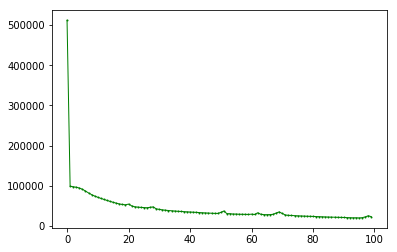

In [29]:
# LOSS GRAPH
fig, ax = plt.subplots()
ax.plot(range(0,len(loss)), loss, 'go-', linewidth=1, markersize=1)

In [30]:
X = np.array(new_features)
y_family, y_superfamily, y_fold, y_class = [], [], [], []

for pdb in pdb_names:
    p = pdb.split("sample")[0]
    y_family.append(label_dict[p])
    y_superfamily.append(".".join(label_dict[p].split(".")[:3]))
    y_fold.append(".".join(label_dict[p].split(".")[:2]))
    y_class.append(".".join(label_dict[p].split(".")[0]))
print(y_family[0], y_superfamily[0], y_fold[0], y_class[0])

('c.119.1.0', 'c.119.1', 'c.119', 'c')


In [31]:
clf = LogisticRegression(random_state=0, penalty="l2", multi_class='multinomial', solver='lbfgs')
pdbClassifier(X, y_fold , label_dict, clf)

Number of labels: 10

Stratified Cross Validation - 1
Training...
Train accuracy:  0.9017857142857143
Test accuracy:  0.25

Stratified Cross Validation - 2
Training...
Train accuracy:  0.8571428571428571
Test accuracy:  0.2857142857142857

Stratified Cross Validation - 3
Training...
Train accuracy:  0.9196428571428571
Test accuracy:  0.14285714285714285

Stratified Cross Validation - 4
Training...
Train accuracy:  0.9196428571428571
Test accuracy:  0.21428571428571427

Stratified Cross Validation - 5
Training...
Train accuracy:  0.875
Test accuracy:  0.2857142857142857

Stratified Cross Validation - 6
Training...
Train accuracy:  0.8839285714285714
Test accuracy:  0.17857142857142858

Stratified Cross Validation - 7
Training...
Train accuracy:  0.8482142857142857
Test accuracy:  0.32142857142857145

Stratified Cross Validation - 8
Training...
Train accuracy:  0.8928571428571429
Test accuracy:  0.25

Stratified Cross Validation - 9
Training...
Train accuracy:  0.9732142857142857
Test ac